In [159]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [160]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [161]:
angry=pd.read_csv('../input/emotions/Emotion(angry).csv')
happy=pd.read_csv('../input/emotions/Emotion(happy).csv')
sad=pd.read_csv('../input/emotions/Emotion(sad).csv')
neutral=pd.read_csv('../input/emotions/Neutral.csv')[['sentiment','content']]

df = pd.concat([angry,happy,sad,neutral])
df

,content,sentiment
0,"Sometimes I’m not angry, I’m hurt and there’s ...",angry
1,Not available for busy people☺,angry
2,I do not exist to impress the world. I exist t...,angry
3,Everything is getting expensive except some pe...,angry
4,My phone screen is brighter than my future 🙁,angry
...,...,...
8633,@shonali I think the lesson of the day is not ...,neutral
8634,@lovelylisaj can you give me the link for the ...,neutral
8635,@jasimmo Ooo showing of your French skills!! l...,neutral
8636,"@sendsome2me haha, yeah. Twitter has many uses...",neutral


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


neutral    8638
happy       708
angry       696
sad         635
Name: sentiment, dtype: int64

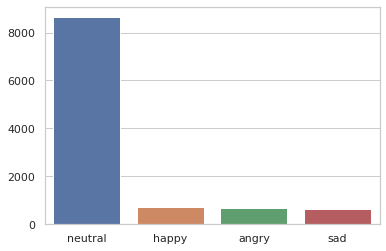

In [162]:
## pie chart of the distribution of the dialects
count_values = df['sentiment'].value_counts()
sns.set(style="whitegrid")
sns.barplot(count_values.index,count_values.values)
count_values

In [163]:
import re
def remove_hashtags(text):
    text = re.sub(r'@\w+', '', text)
    return text
def remove_emojis(text):
    text = [x for x in text.split(' ') if x.isalpha()]
    text = ' '.join(text)
    return text
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def remove_urls(text):
    text = re.sub(r'http\S+', '', text)
    return text
def preprocess(text):
    text = remove_hashtags(text)
    text = remove_emoji(text)
    text = remove_urls(text)
    return text

df['content'] = df['content'].apply(preprocess)


In [164]:
# df.drop_duplicates(inplace=True)
# df.dropna(inplace=True)
df_data=pd.DataFrame(columns=['content','sentiment'])
for i in np.unique(df['sentiment']):
    temp=df.loc[df['sentiment']==i].iloc[:700]
    print(temp.shape)
    df_data=df_data.append(temp,ignore_index=True)
    
X=df_data['content']
Y=df_data['sentiment']
df_data.shape

enc=LabelEncoder()
Y=enc.fit_transform(Y)

(696, 2)
(700, 2)
(700, 2)
(635, 2)


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


happy      700
neutral    700
angry      696
sad        635
Name: sentiment, dtype: int64

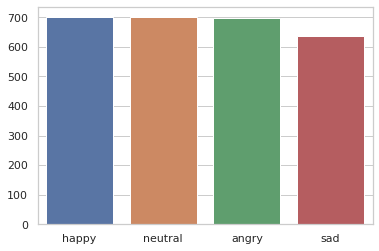

In [165]:
## pie chart of the distribution of the dialects
count_values = df_data['sentiment'].value_counts()
sns.set(style="whitegrid")
sns.barplot(count_values.index,count_values.values)
count_values

In [166]:
X_train , X_test ,y_train,y_test = train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=42)

In [167]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.pipeline import Pipeline
import seaborn as sns

def train_model(model, data, targets):
    text_clf = Pipeline([
    ('vect', CountVectorizer(analyzer='char_wb',ngram_range=(4,7),stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('clf', model),
    ])
    text_clf.fit(data, targets)
    return text_clf
def get_accuracy(trained_model,X, y):
    predicted = trained_model.predict(X)
    accuracy = np.mean(predicted == y)
    return accuracy
def get_report(trained_model,X, y):
    plt.figure(figsize=(10,10))
    predicted = trained_model.predict(X)
    cr = classification_report(y,predicted,target_names=enc.classes_)
    cm=confusion_matrix(y,predicted)
    df_cm=pd.DataFrame(cm,index=enc.classes_)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 10},fmt='g') # font size
    plt.show()
    print(cr)

## LogisticRegression

Test dataset accuracy with LogisticRegression: 0.77


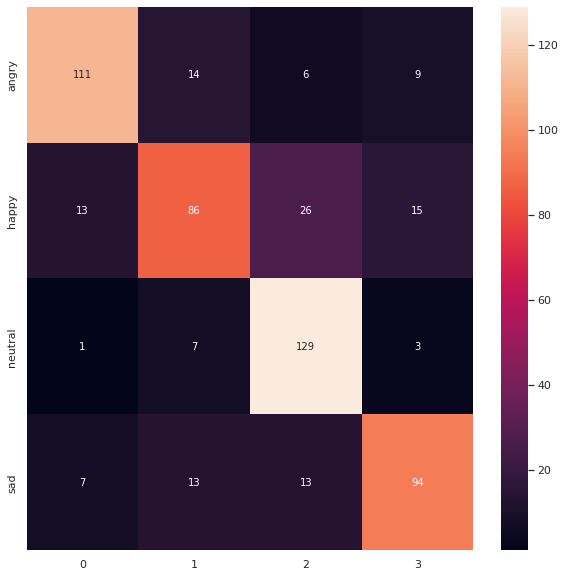

              precision    recall  f1-score   support

       angry       0.84      0.79      0.82       140
       happy       0.72      0.61      0.66       140
     neutral       0.74      0.92      0.82       140
         sad       0.78      0.74      0.76       127

    accuracy                           0.77       547
   macro avg       0.77      0.77      0.76       547
weighted avg       0.77      0.77      0.76       547



In [168]:
from sklearn.linear_model import LogisticRegression
trained_clf_LogisticRegression = train_model(LogisticRegression(), X_train, y_train)
accuracy = get_accuracy(trained_clf_LogisticRegression,X_test, y_test)
print(f"Test dataset accuracy with LogisticRegression: {accuracy:.2f}")
get_report(trained_clf_LogisticRegression,X_test, y_test)

## SVM

Test dataset accuracy with LinearSVC: 0.77


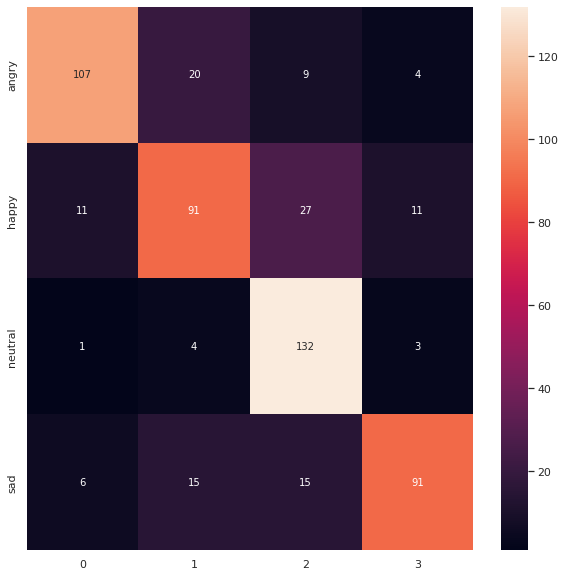

              precision    recall  f1-score   support

       angry       0.86      0.76      0.81       140
       happy       0.70      0.65      0.67       140
     neutral       0.72      0.94      0.82       140
         sad       0.83      0.72      0.77       127

    accuracy                           0.77       547
   macro avg       0.78      0.77      0.77       547
weighted avg       0.78      0.77      0.77       547



In [169]:
from sklearn.svm import SVC
trained_clf_linearSVC = train_model(SVC(), X_train, y_train)
accuracy = get_accuracy(trained_clf_linearSVC,X_test, y_test)
print(f"Test dataset accuracy with LinearSVC: {accuracy:.2f}")
get_report(trained_clf_linearSVC,X_test, y_test)


## MLP

Iteration 1, loss = 1.31470314
Iteration 2, loss = 1.08419486
Iteration 3, loss = 0.87806966


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Test dataset accuracy with MLPClassifier: 0.71


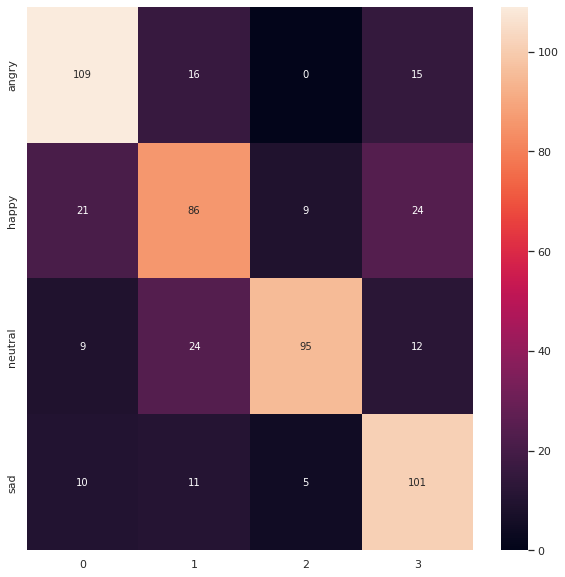

              precision    recall  f1-score   support

       angry       0.73      0.78      0.75       140
       happy       0.63      0.61      0.62       140
     neutral       0.87      0.68      0.76       140
         sad       0.66      0.80      0.72       127

    accuracy                           0.71       547
   macro avg       0.72      0.72      0.72       547
weighted avg       0.73      0.71      0.72       547



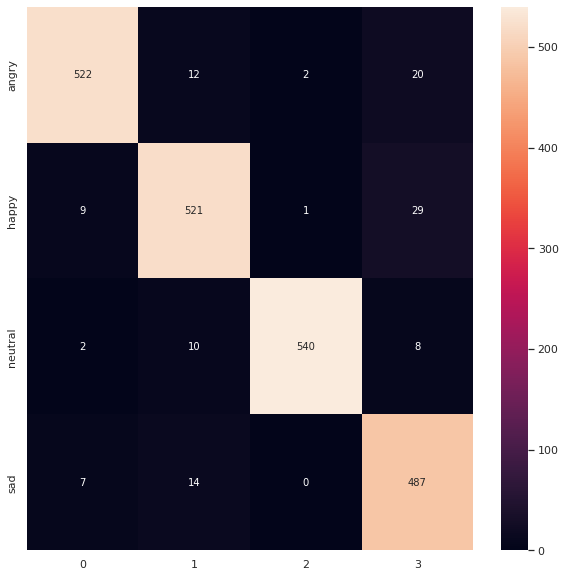

              precision    recall  f1-score   support

       angry       0.97      0.94      0.95       556
       happy       0.94      0.93      0.93       560
     neutral       0.99      0.96      0.98       560
         sad       0.90      0.96      0.93       508

    accuracy                           0.95      2184
   macro avg       0.95      0.95      0.95      2184
weighted avg       0.95      0.95      0.95      2184



In [170]:
from sklearn.neural_network import MLPClassifier
trained_clf_MLPClassifier = train_model(MLPClassifier(verbose=1,max_iter=3,validation_fraction=0.1), X_train, y_train)
accuracy = get_accuracy(trained_clf_MLPClassifier,X_test, y_test)
print(f"Test dataset accuracy with MLPClassifier: {accuracy:.2f}")
get_report(trained_clf_MLPClassifier,X_test, y_test)
get_report(trained_clf_MLPClassifier,X_train, y_train)

## Decision Tree

Test dataset accuracy with MLPClassifier: 0.67


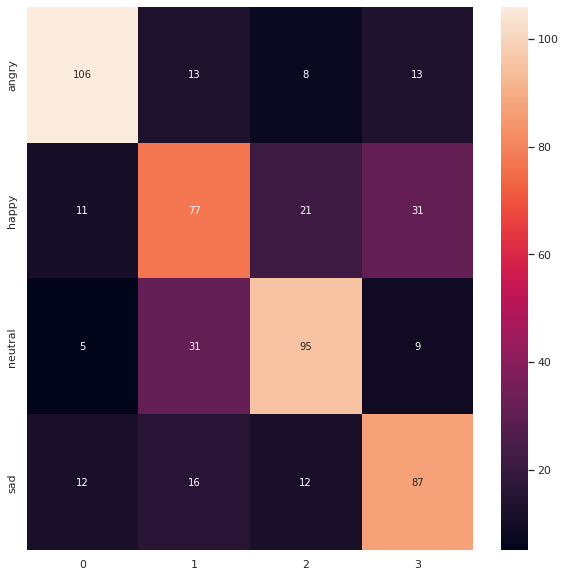

              precision    recall  f1-score   support

       angry       0.79      0.76      0.77       140
       happy       0.56      0.55      0.56       140
     neutral       0.70      0.68      0.69       140
         sad       0.62      0.69      0.65       127

    accuracy                           0.67       547
   macro avg       0.67      0.67      0.67       547
weighted avg       0.67      0.67      0.67       547



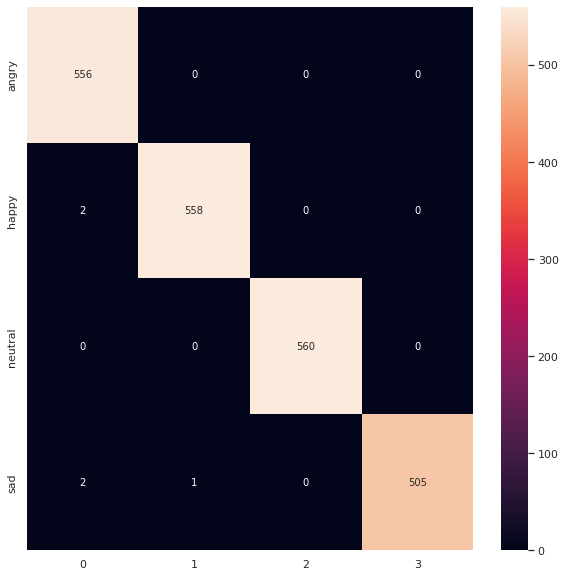

              precision    recall  f1-score   support

       angry       0.99      1.00      1.00       556
       happy       1.00      1.00      1.00       560
     neutral       1.00      1.00      1.00       560
         sad       1.00      0.99      1.00       508

    accuracy                           1.00      2184
   macro avg       1.00      1.00      1.00      2184
weighted avg       1.00      1.00      1.00      2184



In [171]:
from sklearn.tree import DecisionTreeClassifier
trained_clf_DT = train_model(DecisionTreeClassifier(), X_train, y_train)
accuracy = get_accuracy(trained_clf_DT,X_test, y_test)
print(f"Test dataset accuracy with MLPClassifier: {accuracy:.2f}")
get_report(trained_clf_DT,X_test, y_test)
get_report(trained_clf_DT,X_train, y_train)

## RAndom Forest

Test dataset accuracy with MLPClassifier: 0.75


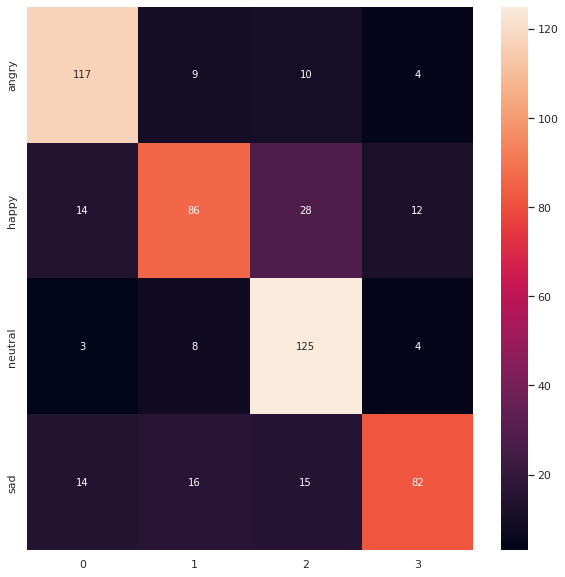

              precision    recall  f1-score   support

       angry       0.79      0.84      0.81       140
       happy       0.72      0.61      0.66       140
     neutral       0.70      0.89      0.79       140
         sad       0.80      0.65      0.72       127

    accuracy                           0.75       547
   macro avg       0.75      0.75      0.74       547
weighted avg       0.75      0.75      0.75       547



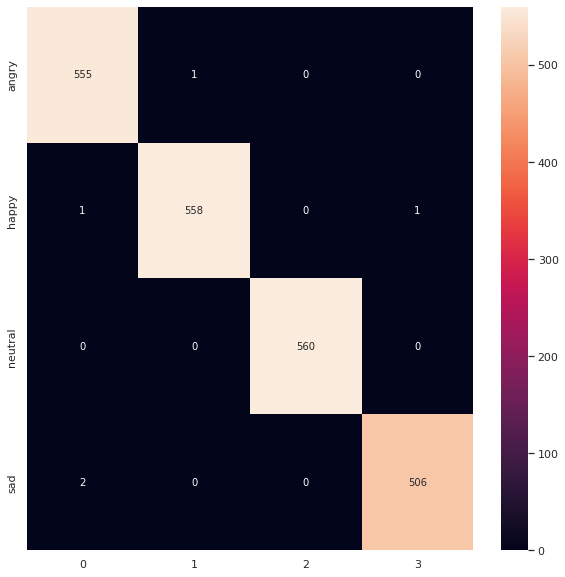

              precision    recall  f1-score   support

       angry       0.99      1.00      1.00       556
       happy       1.00      1.00      1.00       560
     neutral       1.00      1.00      1.00       560
         sad       1.00      1.00      1.00       508

    accuracy                           1.00      2184
   macro avg       1.00      1.00      1.00      2184
weighted avg       1.00      1.00      1.00      2184



In [181]:
from sklearn.ensemble import RandomForestClassifier
trained_clf_RF = train_model(RandomForestClassifier(n_estimators=200), X_train, y_train)
accuracy = get_accuracy(trained_clf_RF,X_test, y_test)
print(f"Test dataset accuracy with MLPClassifier: {accuracy:.2f}")
get_report(trained_clf_RF,X_test, y_test)
get_report(trained_clf_RF,X_train, y_train)

In [182]:
def predict(model,text):
    text=pd.Series(text)
    pred=model.predict(text)
    print(enc.classes_[pred][0])

In [185]:
predict(trained_clf_linearSVC,"i'm very happy to see you" )

happy


In [197]:
predict(trained_clf_linearSVC,"i'm so good" )

neutral


In [199]:
predict(trained_clf_linearSVC,"i'm so angry" )

angry
